In [18]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

%config IPCompleter.greedy = True
%matplotlib inline

In [2]:
# зафиксируем random state для воспроизводимости результатов
RANDOM_STATE = 42

Будем предсказывать зарплату по описанию вакансии - это задача регрессии!

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_first_step_in_nlp/main/datasets/salary_data_cleaned.csv")

In [ ]:
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0


In [11]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel'],
      dtype='object')

Посмотрим на распределение целевой переменной

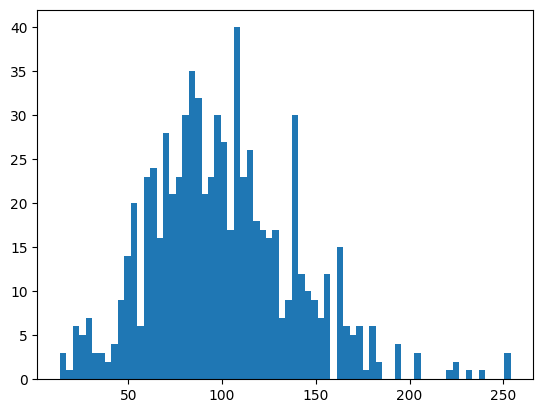

In [4]:
plt.hist(df.avg_salary, bins=70)
plt.show()

Похоже на нормальное. Лучший вариант для линейной регрессии :)

Закодируйте колонку `Job Description` при помощи **tf-idf**

*  попробуйте подобрать гиперпараметры `min_df`, `max_df`, `ngram_range` у метода для достижения наилучшего качества модели

In [23]:
tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 1))
descr = tfidf.fit_transform(df['Job Description'])

**Вопрос:** если использовать `min_df = 5`, `max_df=1.0`, `ngram_range=(1,1)`, то сколько столбцов получится в матрице после применения кодировки?

In [13]:
descr

<742x4640 sparse matrix of type '<class 'numpy.float64'>'
	with 203494 stored elements in Compressed Sparse Row format>

Разобъем данные на тренировочные и тестовые.

Здесь f - это матрица, полученная в результате кодирования столбца `Job Description`.

In [24]:
trX, teX, trY, teY = train_test_split(descr, df["avg_salary"], test_size=0.2, random_state=RANDOM_STATE)

Обучите линейную регрессию под названием Ridge на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных.

**model = Ridge(alpha=1.1)**

In [31]:
clf = Ridge(alpha=1.1).fit(trX, trY)

Посчитаем метрику качества предсказания $R^2$. Чем ближе она к 1, тем лучше качество модели.

Посчитайте значение $R^2$ на тренировочных и на тестовых данных.

**Вопрос:** чему равен $R^2$ на тесте?

In [30]:
train_pred = model.predict(trX)
y_pred = model.predict(teX)
r2_score(teY, y_pred)

0.6191311743257972

Потестируем нашу модель. Посмотрим. как она оценивает зарплаты :)

In [32]:
clf.predict(tfidf.transform([u"director"]))

array([94.31173053])

In [33]:
clf.predict(tfidf.transform([u"manager"]))

array([84.64301931])

**Вопрос:** посчитайте зарплату "data scientist" при помощи модели.

In [34]:
clf.predict(tfidf.transform([u"data scientist"]))

array([114.98662507])

Посмотрим на веса модели

**Вопрос:** какой признак имеет наибольший положительный вес?


In [40]:
%%time
coefs = sorted(zip(list(np.array(tfidf.get_feature_names_out())[clf.coef_ != 0]), clf.coef_[clf.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])

CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 58.1 ms


In [41]:
coefs

,ngram,weight
0,actuarial,36.893315
1,platform,36.890454
2,credit,35.609417
3,climate,35.009046
4,predictive,33.149911
...,...,...
4635,hospital,-29.456601
4636,reporting,-31.522382
4637,marketing,-32.557034
4638,environmental,-34.053000
